<a href="https://colab.research.google.com/github/chungntu/1DCNN-LSTM-ResNet/blob/main/Problem_17_Thin_plate_in_traction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Displacements
  1   0.00000000
  2   0.00250000
  3   0.00500000
  4   0.00750000
  5   0.01000000
  6   0.01250000
  7   0.01500000
  8   0.01750000
  9   0.02000000
 10   0.02250000
 11   0.02500000
 12   0.02750000
 13   0.03000000
 14   0.03250000
 15   0.03500000
 16   0.03750000
 17   0.04000000
 18   0.04250000
 19   0.04500000
 20   0.04750000
 21   0.05000000
 22   0.00000000
 23   0.00250000
 24   0.00500000
 25   0.00750000
 26   0.01000000
 27   0.01250000
 28   0.01500000
 29   0.01750000
 30   0.02000000
 31   0.02250000
 32   0.02500000
 33   0.02750000
 34   0.03000000
 35   0.03250000
 36   0.03500000
 37   0.03750000
 38   0.04000000
 39   0.04250000
 40   0.04500000
 41   0.04750000
 42   0.05000000
 43   0.00000000
 44   0.00250000
 45   0.00500000
 46   0.00750000
 47   0.01000000
 48   0.01250000
 49   0.01500000
 50   0.01750000
 51   0.02000000
 52   0.02250000
 53   0.02500000
 54   0.02750000
 55   0.03000000
 56   0.03250000
 57   0.03500000
 58   0.03750000


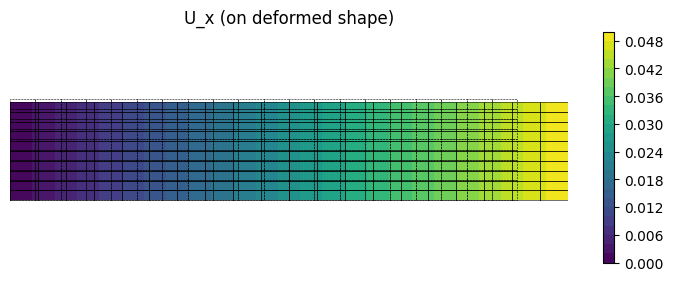

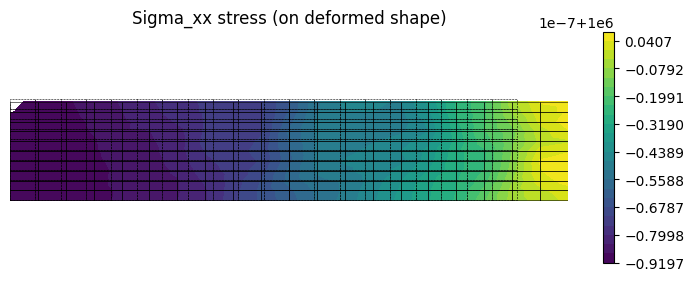

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

# ============================================================
# gaussQuadrature(option) for Q4 elements
# ============================================================
def gaussQuadrature(option='complete'):
    if option == 'complete':  # 2x2
        a = 0.577350269189626
        locations = np.array([
            [-a, -a],
            [ a, -a],
            [ a,  a],
            [-a,  a],
        ], dtype=float)
        weights = np.array([1, 1, 1, 1], dtype=float)
    elif option == 'reduced':  # 1x1
        locations = np.array([[0.0, 0.0]], dtype=float)
        weights = np.array([4.0], dtype=float)
    else:
        raise ValueError("option must be 'complete' or 'reduced'")
    return weights, locations


# ============================================================
# shapeFunctionQ4(xi, eta) (MATCH MATLAB)
# returns shape (4,), naturalDerivatives (4x2) where columns are dN/dxi, dN/deta
# ============================================================
def shapeFunctionQ4(xi, eta):
    shape = 0.25 * np.array([
        (1-xi)*(1-eta),
        (1+xi)*(1-eta),
        (1+xi)*(1+eta),
        (1-xi)*(1+eta),
    ], dtype=float)

    naturalDerivatives = 0.25 * np.array([
        [-(1-eta), -(1-xi)],
        [ (1-eta), -(1+xi)],
        [ (1+eta),  (1+xi)],
        [-(1+eta),  (1-xi)],
    ], dtype=float)  # rows: node 1..4 ; col0=dN/dxi, col1=dN/deta

    return shape, naturalDerivatives


# ============================================================
# Jacobian(nodeCoordinates_element (4x2), naturalDerivatives (4x2))
# MATCH MATLAB:
#   JacobianMatrix = nodeCoordinates' * naturalDerivatives
#   invJacobian = inv(JacobianMatrix)
#   XYderivatives = naturalDerivatives * invJacobian
# ============================================================
def Jacobian(nodeCoords_elem, naturalDerivatives):
    # nodeCoords_elem: (4,2) = [x y] for 4 nodes
    JacobianMatrix = nodeCoords_elem.T @ naturalDerivatives  # (2x4)(4x2)->(2x2)
    invJacobian = np.linalg.inv(JacobianMatrix)
    XYderivatives = naturalDerivatives @ invJacobian         # (4x2)(2x2)->(4x2)
    return JacobianMatrix, invJacobian, XYderivatives


# ============================================================
# rectangularMesh(Lx, Ly, nEx, nEy) for Q4
# Returns:
#   nodeCoordinates (nNodes x 2)
#   elementNodes    (nElements x 4)  1-based, counter-clockwise
# ============================================================
def rectangularMesh(Lx, Ly, nEx, nEy):
    xs = np.linspace(0.0, Lx, nEx + 1)
    ys = np.linspace(0.0, Ly, nEy + 1)
    X, Y = np.meshgrid(xs, ys)  # shape (nEy+1, nEx+1)

    nodeCoordinates = np.column_stack([X.ravel(), Y.ravel()])

    def node_id(ix, iy):
        return iy*(nEx+1) + ix + 1  # 1-based

    elementNodes = []
    for iy in range(nEy):
        for ix in range(nEx):
            n1 = node_id(ix,   iy)
            n2 = node_id(ix+1, iy)
            n3 = node_id(ix+1, iy+1)
            n4 = node_id(ix,   iy+1)
            elementNodes.append([n1, n2, n3, n4])

    return nodeCoordinates, np.array(elementNodes, dtype=int)


# ============================================================
# formStiffness2D (plane stress Q4) - MATCH MATLAB structure
# Returns stiffness, mass (mass included but not needed here)
# ============================================================
def formStiffness2D(GDoF, numberElements, elementNodes, numberNodes, nodeCoordinates,
                    C, rho=1.0, thickness=1.0):

    stiffness = np.zeros((GDoF, GDoF), dtype=float)
    mass = np.zeros((GDoF, GDoF), dtype=float)

    gaussWeights, gaussLocations = gaussQuadrature('complete')

    for e in range(numberElements):
        indice = elementNodes[e, :]              # 1-based, length 4
        nodes = indice.astype(int) - 1           # 0-based indices

        # MATLAB: elementDof = [indice  indice+numberNodes]
        elementDof_1based = np.hstack([indice, indice + numberNodes])
        elementDof = elementDof_1based.astype(int) - 1

        ndof = len(indice)  # 4

        # cycle for Gauss point
        for q in range(len(gaussWeights)):
            xi, eta = gaussLocations[q, 0], gaussLocations[q, 1]
            wt = gaussWeights[q]

            shapeFunction, naturalDerivatives = shapeFunctionQ4(xi, eta)
            Jac, invJac, XYderivatives = Jacobian(nodeCoordinates[nodes, :], naturalDerivatives)

            # B matrix (3 x 2*ndof)
            B = np.zeros((3, 2*ndof), dtype=float)
            # MATLAB:
            # B(1,1:ndof)         = dN/dx
            # B(2,ndof+1:2*ndof)  = dN/dy
            # B(3,1:ndof)         = dN/dy
            # B(3,ndof+1:2*ndof)  = dN/dx
            dNdx = XYderivatives[:, 0]
            dNdy = XYderivatives[:, 1]
            B[0, 0:ndof]       = dNdx
            B[1, ndof:2*ndof]  = dNdy
            B[2, 0:ndof]       = dNdy
            B[2, ndof:2*ndof]  = dNdx

            detJ = np.linalg.det(Jac)

            stiffness[np.ix_(elementDof, elementDof)] += (B.T @ C @ B) * wt * detJ * thickness

            # mass blocks (as MATLAB; not used in this static problem)
            NN = np.outer(shapeFunction, shapeFunction) * rho * thickness * wt * detJ
            mass[np.ix_(nodes, nodes)] += NN
            mass[np.ix_(nodes + numberNodes, nodes + numberNodes)] += NN

    return stiffness, mass


# ============================================================
# solution with prescribed DOF fixed to 0
# ============================================================
def solution(GDoF, prescribedDof_1based, stiffness, force):
    prescribed = np.array(prescribedDof_1based, dtype=int) - 1
    all_dofs = np.arange(GDoF)
    free = np.setdiff1d(all_dofs, prescribed)

    U = np.zeros((GDoF,), dtype=float)
    U[free] = np.linalg.solve(stiffness[np.ix_(free, free)], force[free])
    U[prescribed] = 0.0
    return U


# ============================================================
# stresses2D (compute stress at Gauss points, then average to nodes)
# We'll compute sigma_xx at nodes by averaging element Gauss-point stresses.
# ============================================================
def stresses2D(numberElements, elementNodes, numberNodes, nodeCoordinates,
               displacements, C):
    gaussWeights, gaussLocations = gaussQuadrature('complete')

    # accumulate sigma_xx to nodes
    sigxx_sum = np.zeros(numberNodes, dtype=float)
    sigxx_cnt = np.zeros(numberNodes, dtype=float)

    UX = displacements[:numberNodes]
    UY = displacements[numberNodes:]

    for e in range(numberElements):
        indice = elementNodes[e, :]
        nodes = indice.astype(int) - 1

        elementDof = np.hstack([nodes, nodes + numberNodes])
        ue = np.hstack([UX[nodes], UY[nodes]])  # length 8

        # stresses at 4 Gauss points
        for q in range(len(gaussWeights)):
            xi, eta = gaussLocations[q, 0], gaussLocations[q, 1]

            _, naturalDerivatives = shapeFunctionQ4(xi, eta)
            Jac, invJac, XYderivatives = Jacobian(nodeCoordinates[nodes, :], naturalDerivatives)

            dNdx = XYderivatives[:, 0]
            dNdy = XYderivatives[:, 1]

            B = np.zeros((3, 8), dtype=float)
            B[0, 0:4] = dNdx
            B[1, 4:8] = dNdy
            B[2, 0:4] = dNdy
            B[2, 4:8] = dNdx

            strain = B @ ue
            stress = C @ strain  # [sigma_xx, sigma_yy, tau_xy]

            # distribute sigma_xx to the 4 element nodes (simple average)
            sigxx_sum[nodes] += stress[0]
            sigxx_cnt[nodes] += 1.0

    sigxx = sigxx_sum / np.maximum(sigxx_cnt, 1.0)
    return sigxx


# ============================================================
# Visualization helpers
# ============================================================
def draw_mesh_edges(nodeCoordinates, elementNodes, ax, color='k', lw=0.6, ls='-'):
    for elem in elementNodes:
        ids = elem.astype(int) - 1
        poly = np.vstack([nodeCoordinates[ids, :], nodeCoordinates[ids[0], :]])
        ax.plot(poly[:, 0], poly[:, 1], color=color, lw=lw, ls=ls)

def q4_to_triangles(elementNodes):
    # split each quad (n1,n2,n3,n4) into (n1,n2,n3) and (n1,n3,n4)
    tris = []
    for e in elementNodes:
        n1, n2, n3, n4 = (e.astype(int) - 1)
        tris.append([n1, n2, n3])
        tris.append([n1, n3, n4])
    return np.array(tris, dtype=int)


# ============================================================
# MAIN (problem17.m)
# ============================================================
# materials
E = 10e7
poisson = 0.30

# plane stress constitutive matrix (as MATLAB)
C = (E/(1-poisson**2)) * np.array([
    [1, poisson, 0],
    [poisson, 1, 0],
    [0, 0, (1-poisson)/2]
], dtype=float)

# load
P = 1e6

# mesh
Lx = 5.0
Ly = 1.0
numberElementsX = 20
numberElementsY = 10
numberElements = numberElementsX * numberElementsY

nodeCoordinates, elementNodes = rectangularMesh(Lx, Ly, numberElementsX, numberElementsY)
xx = nodeCoordinates[:, 0]
yy = nodeCoordinates[:, 1]
numberNodes = nodeCoordinates.shape[0]

# DOF
GDoF = 2 * numberNodes

# stiffness
stiffness, _ = formStiffness2D(GDoF, numberElements, elementNodes, numberNodes,
                               nodeCoordinates, C, rho=1.0, thickness=1.0)

# boundary conditions
fixedNodeX = np.where(np.isclose(nodeCoordinates[:, 0], 0.0))[0] + 1  # 1-based
fixedNodeY = np.where(np.isclose(nodeCoordinates[:, 1], 0.0))[0] + 1  # 1-based
prescribedDof = np.hstack([fixedNodeX, fixedNodeY + numberNodes]).tolist()

# force vector (distributed load applied at x=Lx in X direction)
force = np.zeros((GDoF,), dtype=float)
rightBord = np.where(np.isclose(nodeCoordinates[:, 0], Lx))[0]  # 0-based node ids on right edge

# MATLAB:
# force(rightBord) = P*Ly/numberElementsY;
# force(rightBord(1)) = P*Ly/numberElementsY/2;
# force(rightBord(end)) = P*Ly/numberElementsY/2;
edge_load = P * Ly / numberElementsY
force[rightBord] = edge_load
force[rightBord[0]] *= 0.5
force[rightBord[-1]] *= 0.5

# solve
displacements = solution(GDoF, prescribedDof, stiffness, force)

print("Displacements")
for i in range(GDoF):
    print(f"{i+1:3d}  {displacements[i]: .8f}")

UX = displacements[:numberNodes]
UY = displacements[numberNodes:]

scaleFactor = 10.0
nodeDef = nodeCoordinates + scaleFactor * np.column_stack([UX, UY])

# stresses at nodes (sigma_xx)
sigxx = stresses2D(numberElements, elementNodes, numberNodes, nodeCoordinates,
                   displacements, C)

# --- plot Ux field on deformed shape (similar to drawingField) ---
tris = q4_to_triangles(elementNodes)
triang = Triangulation(nodeDef[:, 0], nodeDef[:, 1], tris)

plt.figure(figsize=(9, 3))
plt.tricontourf(triang, UX, levels=30)
plt.colorbar()
ax = plt.gca()
draw_mesh_edges(nodeDef, elementNodes, ax, color='k', lw=0.4, ls='-')
draw_mesh_edges(nodeCoordinates, elementNodes, ax, color='k', lw=0.4, ls='--')
plt.title("U_x (on deformed shape)")
plt.axis('equal')
plt.axis('off')
plt.show()

# --- plot sigma_xx field on deformed shape ---
plt.figure(figsize=(9, 3))
plt.tricontourf(triang, sigxx, levels=30)
plt.colorbar()
ax = plt.gca()
draw_mesh_edges(nodeDef, elementNodes, ax, color='k', lw=0.4, ls='-')
draw_mesh_edges(nodeCoordinates, elementNodes, ax, color='k', lw=0.4, ls='--')
plt.title("Sigma_xx stress (on deformed shape)")
plt.axis('equal')
plt.axis('off')
plt.show()
